<a href="https://colab.research.google.com/github/mahmoudmastouri/EM-PCA-Bayes/blob/master/EM_PCA_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Machine Learning Project

`In this project, we will study the labelling of an unsupervised Data using Expectation-Maximization (EM) algorithm then we will perform a dimensions reduction using Principal Compononets Analysis (PCA) in order to have low dimensional labelled data that we can perform a Bayes classifier on it`

# Data acquisition
We will use synthetic data ( generated from a Gaussian mixture ) in order to have a clear error detection that will help to measure these algorithm performances.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using the probability density function ( PDF ) of the Gaussian distribution to generate the data: </br>
$ p(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2} } $

In [ ]:
def gen_gaussian_mix(sigma, mu, N,distr_nb):
    gaussians_dist = []
    size_distr = int(N/distr_nb)
    for i in range(distr_nb):
        gaussians_dist.append(np.random.multivariate_normal(mu[i],sigma[i],size_distr))
    return np.vstack(gaussians_dist)

## Globale Params


In [ ]:
Dimension = 20
N= 10000
K = 5

## Generating Gaussian Mixture

In [ ]:
sigmas = [ np.eye(Dimension) for _ in range(K)]

mu1 = np.ones(Dimension) 
mus = [0*mu1, -5*mu1, -2*mu1, mu1*2, mu1*5]
data = gen_gaussian_mix(sigmas,mus, N, K)
TrueLables = np.zeros((N,1))
class_size = int(N/K)
for i in range(class_size):
  for k in range(K):
    TrueLables[i + class_size*k] = int(k)
data_labeled = np.concatenate((data, TrueLables), axis=-1)
np.random.shuffle(data_labeled)
data = data_labeled[:,:-1].copy()
TrueLables = data_labeled[:,-1:].copy()

# Expectation-Maximization (EM)

Our hypothesis in this section that there is a $K$ classes and $d$ dimension ($K,d \in 𝚴^*$) in our data and each class follows a gaussian low to build out a gaussian distrubition.</br>
We can write $\vec{X_k}$~$N(\vec{\mu}_k,\Sigma_k)$, where:</br>
* $ \mu \in ℜ^d$
* $ \Sigma \in ℜ^{d×d}$

The multivariate normal distribution in d-dimensions, also called the multivariate Gaussian distribution.
</br> Its density is given by:</br>
$p(\vec{x_k};\mu,\Sigma_k)=\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}exp(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu}))$</br>
The mean is (unsurprisingly) given by $\mu$:</br>
$E[X]=∫_xxp(x;\mu,Σ)dx=\mu$</br>
The <b>covariance</b> of vector-value random varialble $Z$ is defined as $Cov(Z)=E[(Z-E[Z])(Z-E[Z])^T]=E[ZZ]-(E[Z])(E[Z])^T=Σ$</br>
<hr>
We know from Bayes rule to derive the posterior distribution on y given x:</br>
$p(y|x)=\frac{p(x|y)p(y)}{p(x)}.$</br>
Actually, if were calculating
p(y|x) in order to make a prediction, then we don’t actually need to calculate
the denominator, since:

$\underset{y}{\operatorname{argmin}}p(y|x)=\underset{y}{\operatorname{argmin}}\frac{p(x|y)p(y)}{p(x)}=\underset{y}{\operatorname{argmin}}p(x|y)p(y)$
</br> </br>
We will assume that these N points are
drawn from K Gaussian distributions, with
the $ℓ^{th}$ distribution characterized by the parameters $θ_ℓ = \{\vec{µ}_ℓ, Σ_ℓ\}$, where $\vec{µ}_ℓ$
is the
mean and $Σ_ℓ$
the covariance. We also assume that the different Gaussian distributions do not carry equal weight with regard
to their contributions to the observed data.
We will represent this fact by associating
a prior probability aℓ with the $ℓ^{th}$ Gaussian.

## References
*  https://www.youtube.com/watch?v=DODphRRL79c [Gaussian Mixture Models for Clustering]
* https://www.youtube.com/watch?v=rVfZHWTwXSA [Lecture 14 - Expectation-Maximization Algorithms | Stanford CS229: Machine Learning (Autumn 2018)]
* https://engineering.purdue.edu/kak/Tutorials/ExpectationMaximization.pdf [Expectation-Maximization Algorithm for
Clustering Multidimensional Numerical
Data] [Important]

## Initialisation

Our Initialisation step is important to reduce the convergence iteration number:
- $ r_{k}^0= \frac{1}{K}$
- $ \mu^0_k = \frac{K}{N} x_i| y_i = k $
- $ (\sigma^0_k)^2 = \frac{K}{N} (x_i-\mu^0_k)^2_{|y_i=k}$

For Initialisation we suppose that: </br>
* $\vec{x_{1..K}}\text{ ~ }𝒩(\mu_K^0,\Sigma_K^0)$
* $\vec{x_{K..K+1}}\text{ ~ }𝒩(\mu_{K+1}^0,\Sigma_{K+1}^0)$
* $...$
* $\vec{x_{N-K..N}}\text{ ~ }𝒩(\mu_{N}^0,\Sigma_{N}^0)$

In [ ]:
def initialize_params(X,K):
    data_dim = X.shape[1]
    params = {
        "pi": np.ones(K)/K,
        "mu":np.random.randint(min(X[:,0]),max(X[:,0]),size=(K,data_dim)),
        "cov":np.zeros((K,data_dim,data_dim)),
    }
    for dim in range(len(params["cov"])):
        np.fill_diagonal(params["cov"][dim],5)
    return params

## E-Step

1. Calculate for each datapoint $x_i$
 the probability $r_{ic}$
 that datapoint $x_i$ 
 belongs to cluster c with:</br></br>
 $r_{ic}=\frac{\pi_cℕ(x_i|μ_cΣ_c)}{\sum_{k=1}^{K}ℕ(x_i|μ_kΣ_k)}$</br></br> where $ℕ(x_i|μ_cΣ_c)$ describe the multivariate Gaussian with: </br></br>
 $ℕ(x_i|μ_cΣ_c)=\frac{1}{(2π)^{\frac{n}{2}}|Σ_c|^{\frac{1}{2}}}exp(-\frac{1}{2}(x_i-μ_c)^TΣ^{-1}_c(x_i-μ_c))$

2. $r_{ic}$ gives use for each datapoint $x_i$ the measure of:</br>
$\frac{
  \text{Probability that }x_i\text{ belongs to class c}
}{
  \text{Probability of }x_i\text{ over all classes}
}$ hence if $x_i$ is very close to one gaussian $c$, it will get in high $r_{ic}$ value of this gaussian and relatively low valyes otherwises.


In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
def E_step(X, params):
  r_ic = np.zeros((N,K))
  reg_cov =  1e-6*np.identity(len(X[0]))
  for m,co,p,r in zip(params["mu"],params["cov"],params["pi"],range(len(r_ic[0]))):
    co+=reg_cov
    mn = multivariate_normal(mean=m,cov=co)
    r_ic[:,r] = p*mn.pdf(X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c,mu_c,cov_c in zip(params["pi"],params["mu"],params["cov"]+reg_cov)],axis=0)  
  return r_ic

## M-Step

For each cluster c: Calculate the total weight $m_c$
 (loosely speaking the fraction of points allocated to cluster c) and update $π_c$
, $µ_c$
, $\Sigma_c$ and 
 using $r_{ic}$
 with:
 * $m_c = Σ_ir_{ic}$
 * $π_c = \frac{m_c}{m}$
 * $ µ_c = \frac{1}{m_c}  Σ_ir_{ic} (x_i-µ_c)^T(x_i-µ_c)  $

In [ ]:
def M_step(X,params,r_ic):
  mu = []
  cov = []
  pi = []
  reg_cov =  1e-6*np.identity(len(X[0]))
  for c in range(len(r_ic[0])):
    m_c = np.sum(r_ic[:,c],axis=0)
    mu_c = (1/m_c)*np.sum(X*r_ic[:,c].reshape(len(X),1),axis=0)
    mu.append(mu_c)
    # Calculate the covariance matrix per source based on the new mean
    cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(X),1)*(X-mu_c)).T,(X-mu_c)))+reg_cov)
    # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
    pi.append(m_c/np.sum(r_ic)) # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know 
                                    # that the columns of each row of r_ic adds up to 1. Since we add up all elements, we sum up all
                                    # columns per row which gives 1 and then all rows which gives then the number of instances (rows) 
                                    # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
                                    # The elements in pi_new must add up to 1
  log_likelihood = np.log(np.sum([k*multivariate_normal(mu[i],cov[j]).pdf(X) for k,i,j in zip(pi,range(len(mu)),range(len(cov)))]))
  return ({
    "pi": pi,
    "mu":mu,
    "cov":cov
  },log_likelihood)

Iteratively repeat the E and M step until the log-likelihood function of our model converges where the log likelihood is computed with:
$ln(p(𝑿|π,µ,Σ)=\sum_{k=1}^Kln(\sum_{i=1}^N\pi_k𝒩(x_i|µ_k\Sigma_k)))$

In [ ]:
def EM(X, K, max_iter=100):
  params = initialize_params(X,K)    
  log_likelihoods = []
  params_list = []
  for i in range(max_iter):
    r_ic = E_step(X,params)
    new_params, log_likelihood = M_step(X,params,r_ic)
    params_list.append(new_params)
    params = new_params
    log_likelihoods.append(log_likelihood)
  labeling = lambda x :  [ multivariate_normal(mean=m,cov=c).pdf(x)/np.sum([multivariate_normal(mean=mean,cov=cov).pdf(x) for mean,cov in zip(params["mu"],params["cov"])]) for m,c in zip(params["mu"],params["cov"]) ]
  Labels =np.array( [ labeling(X[i,:]) for i in range(N)])
  return (Labels, params_list, log_likelihoods)

In [ ]:
max_iter = 100
Labels, params_list, log_likelihoods = EM(data, K, max_iter)

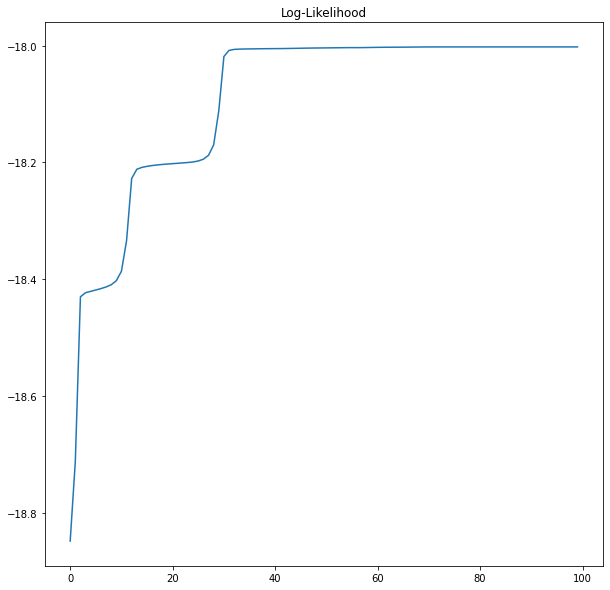

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111) 
ax1.set_title('Log-Likelihood')
ax1.plot(range(0,max_iter,1),log_likelihoods)
plt.show()

# Principal component analysis (PCA)

## Standarize the Data

Stadarize the data: $Z = \frac{x_{i}-mu(x)}{\sigma(x)}$

In [ ]:
def standardize_data(arr):

    rows, columns = arr.shape
    
    standardizedArray = np.zeros(shape=(rows, columns))
    tempArray = np.zeros(rows)
    
    for column in range(columns):
        
        mean = np.mean(arr[:,column])
        std = np.std(arr[:,column])
        tempArray = np.empty(0)
        
        for element in arr[:,column]:
            
            tempArray = np.append(tempArray, ((element - mean) / std))
 
        standardizedArray[:,column] = tempArray
    
    return standardizedArray

## Calculing PCA


1. Calculating the covariance matrix $\Sigma = \frac{1}{n-1}((X-\bar{x})^T(X-\bar{x})$
2. calculating Eigievector(W) and Eigenvalues(V)
3. Calculating the explained variance on each of components  $EV_{i} = \frac{i}{(\sum_{j=1}^{Dimension} V_{j})*100}$
4. Calculating cumulative variance explained
5. Picking D Eigenvalues that satisfies: cumulative variance sum > the selected threshold
6. Creating projection matrix ($W'$) of the selected Eigievectors
7. Projecting in the new demension $X_{pca}=X.W'$

In [ ]:
def PCA(data, PCA_cumulative_variance_threshold=70, force_dim=None):
    data_std = standardize_data(data)
    
    # Calculating the covariance matrix
    covariance_matrix = np.cov(data_std.T)
    
    # calculating Eigievector and Eigenvalues
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    
    # We want to see how much of the variance in data is explained by each one of these components. 
    #It is make more sens to use a maximum of the explained variance
    # Calculating the explained variance on each of components
    variance_explained = []
    for i in eigen_values:
         variance_explained.append((i/sum(eigen_values))*100)
    print("Variance_explained =")
    print(variance_explained)
    # Identifying components that explain at least PCA_cumulative_variance_threshold%
    cumulative_variance_explained = np.cumsum(variance_explained)
    print("Cumulative_variance_explained =")   
    print(cumulative_variance_explained)
    # Picking the minimun nember of cumulative variance the achieve the threshold Then, this number
    new_demensions_size = len([i for i in range(len(cumulative_variance_explained)) if cumulative_variance_explained[i] <= PCA_cumulative_variance_threshold])
    new_demensions_size = new_demensions_size if new_demensions_size>0 else 1
    print("New demension = ",new_demensions_size)
    # picking new demensions    
    # forcing demesions to nb_gaussian_mix to easy visaulization
    if force_dim!=None:
      print("New dimension forced to be ",force_dim)
      new_demensions_size = force_dim
    eigPositions = (-eigen_values).argsort()[:new_demensions_size]
    projection_matrix = np.zeros((Dimension,new_demensions_size))
    for i in range(len(eigPositions)):
        eigPos = eigPositions[i]
        projection_matrix[:,i] = eigen_vectors[eigPos,:].T    
        
    return data.dot(projection_matrix),cumulative_variance_explained

In [ ]:
data_reduced,_ = PCA(data, PCA_cumulative_variance_threshold=75, force_dim=3)

Variance_explained =
[92.46299370422157, 0.4328899187687924, 0.42713599287530307, 0.4221669200761146, 0.366628158279348, 0.4162160902793748, 0.37153581851520157, 0.37282437816004194, 0.37584221716323923, 0.4113362643862519, 0.4084441814647319, 0.3801234654275455, 0.3831789199138317, 0.4053438282858984, 0.3993204446723455, 0.39872420676543624, 0.3880847006448874, 0.3948010730743452, 0.3906531230665075, 0.39175659395921747]
Cumulative_variance_explained =
[ 92.4629937   92.89588362  93.32301962  93.74518654  94.11181469
  94.52803078  94.8995666   95.27239098  95.6482332   96.05956946
  96.46801364  96.84813711  97.23131603  97.63665986  98.0359803
  98.43470451  98.82278921  99.21759028  99.60824341 100.        ]
New demension =  1
New dimension forced to be  3


In [ ]:
data_reduced.shape

(10000, 3)

In [ ]:
def plot_PCA(data_reduced, TrueLables):
  dim = data_reduced.shape[1]
  fig = plt.figure(figsize=(10,10))
  if dim == 3:
    ax = fig.add_subplot(projection='3d')
    x,y,z = data_reduced[:,0],data_reduced[:,1], data_reduced[:,2]
    ax.scatter(x, y, z, marker=".", c=TrueLables/K)
  else:
    ax = fig.add_subplot(111) 
    if dim == 2:
      ax.scatter(data_reduced[:,0], data_reduced[:,1], marker=".", c=TrueLables/K)
    else:
      ax.scatter(data_reduced[:,0], np.zeros_like(data_reduced), marker=".", c=TrueLables/K)
  fig = plt.figure(figsize=(10,10))
  ax.set_title("Representing Data after PCA\n Note: the classes colours' came from the original labels ( not from EM )")
  plt.show()

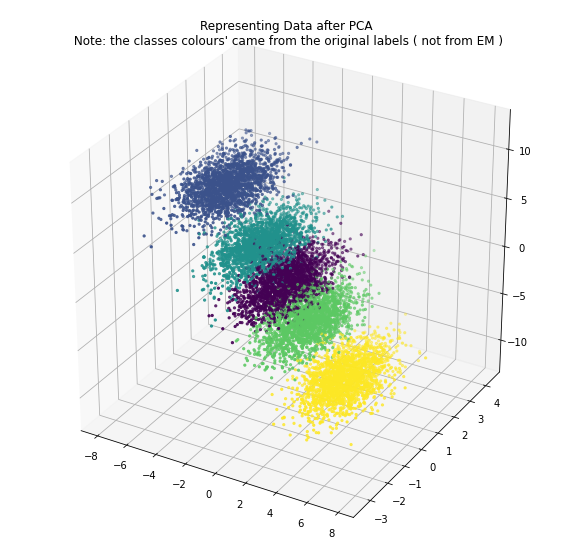

<Figure size 720x720 with 0 Axes>

In [ ]:
plot_PCA(data_reduced, TrueLables)

# Naive Bayes (NB)